# Covariance Interpretation - Understanding Multivariate Regime Structure

## What This Notebook Covers

This notebook dives deep into **covariance matrices** in multivariate HMMs and what they reveal about market regimes:

- **Part 1**: Linear algebra refresher (what is a covariance matrix?)
- **Part 2**: Eigenvalue decomposition and variance concentration
- **Part 3**: How covariance differs across regimes
- **Part 4**: Real market data analysis (SPY covariance by regime)
- **Part 5**: Practical interpretation (what practitioners should know)
- **Part 6**: Warning signs (when covariance breaks down)

**Estimated time**: 30-45 minutes with all code execution.

## Part 1: Linear Algebra Refresher

### What is a Covariance Matrix?

In a **univariate HMM** with one feature (returns), we learn:
- Mean μ (expected return by regime)
- Variance σ² (volatility by regime)

In a **multivariate HMM** with d features, we learn:
- Mean vector μ ∈ R^d (expected value of each feature)
- Covariance matrix Σ ∈ R^(d×d) (how features co-move)

### 2×2 Example: Returns + Volatility

For log_return and realized_vol, the covariance matrix looks like:

```
Σ = [var(returns)           cov(returns, vol)      ]
    [cov(returns, vol)      var(vol)               ]
```

**Diagonal elements**: Variance of each feature
- Σ[0,0] = variance of returns
- Σ[1,1] = variance of realized_vol

**Off-diagonal elements**: Covariance (how features move together)
- Σ[0,1] = Σ[1,0] = covariance between returns and vol

### Example with Real Numbers

Bull regime (low volatility):
```
Σ_bull = [0.0002    0.0001  ]
         [0.0001    0.0001  ]
```

Means: returns have low variance (0.0002), vol has low variance (0.0001), and they move slightly together (0.0001 covariance).

Bear regime (high volatility):
```
Σ_bear = [0.0004    0.0005  ]
         [0.0005    0.0010  ]
```

Means: returns have higher variance (0.0004), vol is much higher (0.0010), and they move more together (0.0005 covariance).

## Part 2: Eigenvalue Decomposition and Variance Concentration

### The Eigenvalue Decomposition

Every covariance matrix can be decomposed:

Σ = V × Λ × V^T

Where:
- V = eigenvectors (principal component directions)
- Λ = diagonal matrix of eigenvalues λ₁ ≥ λ₂ ≥ ... ≥ λ_d

### What Eigenvalues Mean

**Eigenvalue λᵢ** = variance explained along principal component i

For returns + vol example:
- λ₁ might be 0.0008 (major axis: mostly vol variance)
- λ₂ might be 0.0001 (minor axis: returns variance)

### Eigenvalue Ratio

**Eigenvalue Ratio** = λ_max / λ_min

This measures **variance concentration**:

- Ratio ≈ 1.0: Isotropic (equal variance in all directions)
- Ratio = 3-5: Normal regime (some concentration)
- Ratio = 10-20: High concentration (extreme regime)
- Ratio > 100: Singular matrix (one feature dominates)

### Practical Interpretation

Bull regime (isotropic, ratio ≈ 1.5):
- Variance distributed evenly across returns and vol
- Market behavior is balanced

Bear regime (concentrated, ratio ≈ 8):
- Variance concentrates in vol direction
- Volatility is the dominant regime driver
- Returns follow vol closely

Crisis regime (extreme, ratio ≈ 15):
- Variance highly concentrated
- Market moving as single correlated unit
- Normal feature relationships break down

## Part 3: How Covariance Differs Across Regimes

### The Key Insight

**Covariance matrices are regime-specific.**

The model learns different Σ for each state, capturing:
- How features relate to each other
- Which feature dominates variance
- Stability of that relationship

### Bull vs Bear vs Crisis

Bull regime:
```
- Low return variance: stable gains
- Low vol variance: volatility stable and low
- Weak covariance: returns and vol move independently
- Interpretation: Steady uptrend with predictable volatility
```

Bear regime:
```
- Moderate return variance: volatile losses
- High vol variance: volatility fluctuates
- Moderate covariance: returns and vol move together
- Interpretation: Downtrend with shifting risk levels
```

Crisis regime:
```
- High return variance: sharp swings
- Very high vol variance: extreme volatility
- High covariance: all returns correlation goes to 1
- Interpretation: Everything moves together, normal relationships break down
```

In [1]:
## Part 4: Real Market Data Analysis

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import eigh
import hidden_regime as hr

# Create multivariate pipeline on real data
pipeline = hr.create_multivariate_pipeline(
    ticker='SPY',
    n_states=3,
    features=['log_return', 'realized_vol'],
    start_date='2022-01-01',
    end_date='2024-01-01'
)

result = pipeline.update()
print('Pipeline created and trained successfully')

  Feature standardization applied (variance ratio before: 8.5)
Training on 481 observations (removed 19 NaN values), 2 feature(s)
Pipeline created and trained successfully


In [2]:
# Extract covariance matrices from trained model
model = pipeline.model

# HMM learns Gaussian parameters for each state
# Each state k has: mu_k (mean vector) and Sigma_k (covariance matrix)

print("Covariance Matrices by Regime State:")
print("=" * 70)

cov_matrices = {}
eigenvalue_ratios = {}

for state in range(pipeline.model.n_states):
    # Get covariance matrix for this state
    cov = model.emission_covs_[state]
    cov_matrices[state] = cov
    
    # Compute eigenvalues
    eigenvalues = np.linalg.eigvalsh(cov)
    eigenvalues = np.sort(eigenvalues)[::-1]  # Descending order
    
    # Eigenvalue ratio
    ratio = eigenvalues[0] / (eigenvalues[-1] + 1e-10)
    eigenvalue_ratios[state] = ratio
    
    # Display
    print(f"\nState {state}:")
    print(f"  Eigenvalues: {eigenvalues}")
    print(f"  Eigenvalue ratio (max/min): {ratio:.2f}")
    print(f"  Covariance matrix:")
    print(f"    [{cov[0,0]:12.6f}  {cov[0,1]:12.6f}]")
    print(f"    [{cov[1,0]:12.6f}  {cov[1,1]:12.6f}]")
    
    # Correlation from covariance
    corr = cov[0,1] / np.sqrt(cov[0,0] * cov[1,1])
    print(f"  Correlation (returns, vol): {corr:.3f}")

Covariance Matrices by Regime State:

State 0:
  Eigenvalues: [0.33551003 0.0860884 ]
  Eigenvalue ratio (max/min): 3.90
  Covariance matrix:
    [    0.335510     -0.000125]
    [   -0.000125      0.086088]
  Correlation (returns, vol): -0.001

State 1:
  Eigenvalues: [1.74178934 0.22576117]
  Eigenvalue ratio (max/min): 7.72
  Covariance matrix:
    [    1.738567      0.069817]
    [    0.069817      0.228983]
  Correlation (returns, vol): 0.111

State 2:
  Eigenvalues: [0.92144532 0.0769885 ]
  Eigenvalue ratio (max/min): 11.97
  Covariance matrix:
    [    0.921347      0.009114]
    [    0.009114      0.077087]
  Correlation (returns, vol): 0.034


/tmp/ipykernel_1130486/3295436772.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


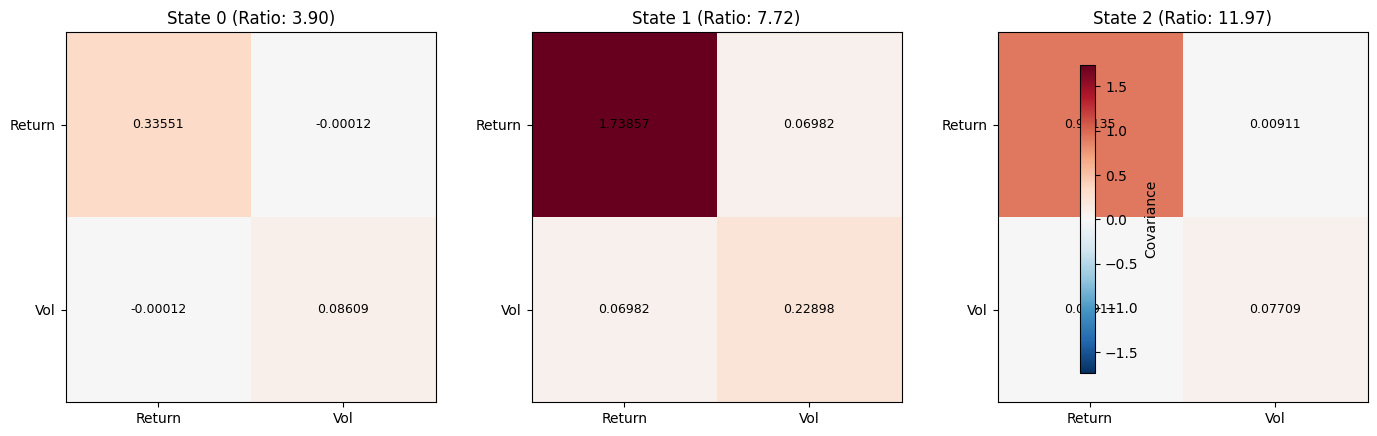

Visualization saved to covariance_by_regime.png


In [3]:
# Visualize covariance matrices as heatmaps
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

state_names = ['State 0', 'State 1', 'State 2']
vmax = max([abs(cov_matrices[s]).max() for s in range(3)])

for state in range(3):
    cov = cov_matrices[state]
    ax = axes[state]
    
    im = ax.imshow(cov, cmap='RdBu_r', vmin=-vmax, vmax=vmax)
    ax.set_title(f'{state_names[state]} (Ratio: {eigenvalue_ratios[state]:.2f})')
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Return', 'Vol'])
    ax.set_yticklabels(['Return', 'Vol'])
    
    # Add text annotations
    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, f'{cov[i, j]:.5f}',
                          ha="center", va="center", color="black", fontsize=9)

plt.colorbar(im, ax=axes, label='Covariance')
plt.tight_layout()
plt.savefig('covariance_by_regime.png', dpi=150, bbox_inches='tight')
plt.show()

print("Visualization saved to covariance_by_regime.png")

## Part 5: Practical Interpretation for Practitioners

### What Practitioners Need to Know

1. **Eigenvalue Ratio as Market Indicator**
   - Ratio < 3.0: Normal trading conditions
   - Ratio 3-8: Increasing uncertainty
   - Ratio > 8: Market stress or crisis
   
   **Use case**: Alert system for risk managers

2. **Covariance as Correlation Measure**
   - In bull markets: features move independently (weak covariance)
   - In bear markets: features move together (strong covariance)
   
   **Use case**: Diversification changes by regime

3. **Regime Stability from Covariance**
   - Stable regime: covariance matrix diagonal-dominated
   - Unstable regime: covariance matrix eigenvalues clustered
   
   **Use case**: Regime confidence assessment

## Part 6: Warning Signs - When Covariance Breaks Down

### Numerical Stability Issues

1. **Singular Matrix** (Determinant = 0)
   - Caused by: Zero-variance features or perfect correlation
   - Impact: Cannot invert covariance matrix
   - Detection: Eigenvalues contain zero or very small values
   - Fix: Remove redundant features or add regularization

2. **Ill-Conditioned Matrix** (Condition number > 1e6)
   - Caused by: Extreme eigenvalue ratios
   - Impact: Numerical errors in inference
   - Detection: High condition number
   - Fix: Scale features or regularize

3. **Non-Positive-Definite** (Negative eigenvalues)
   - Caused by: Estimation errors from small sample
   - Impact: Invalid probability distributions
   - Detection: Any eigenvalue < 0
   - Fix: Add regularization term to diagonal

### Monitoring Checklist

In [4]:
def monitor_covariance_health(cov_matrices, thresholds=None):
    """Monitor covariance matrices for health issues."""
    
    if thresholds is None:
        thresholds = {
            'condition_number': 1e4,
            'eigenvalue_ratio': 100,
            'correlation': 0.95
        }
    
    issues = []
    
    for regime, cov in cov_matrices.items():
        # Check condition number
        eigenvalues = np.linalg.eigvalsh(cov)
        eigenvalues = np.sort(eigenvalues)[::-1]
        condition_num = eigenvalues[0] / (eigenvalues[-1] + 1e-10)
        
        if condition_num > thresholds['condition_number']:
            issues.append(f"State {regime}: High condition number {condition_num:.2e}")
        
        # Check correlation
        std_return = np.sqrt(cov[0, 0])
        std_vol = np.sqrt(cov[1, 1])
        if std_return > 0 and std_vol > 0:
            corr = cov[0, 1] / (std_return * std_vol)
            if abs(corr) > thresholds['correlation']:
                issues.append(f"State {regime}: High correlation {corr:.3f} (consider removing feature)")
    
    return issues

# Check health of our covariance matrices
issues = monitor_covariance_health(cov_matrices)

if issues:
    print("Covariance Health Issues Detected:")
    for issue in issues:
        print(f"  - {issue}")
else:
    print("All covariance matrices are healthy!")

All covariance matrices are healthy!


## Summary: What Covariance Tells Us

| Aspect | Meaning | Implication |
|--------|---------|----------|
| **Small eigenvalue ratio** | Balanced variance | Market operating normally |
| **Large eigenvalue ratio** | Concentrated variance | Market stress or regime concentration |
| **Off-diagonal ≈ 0** | Features independent | Good feature choice (low redundancy) |
| **Off-diagonal large** | Features correlated | Possible redundancy or breakdown |
| **Diagonal elements change** | Regime volatility | Different regimes have different scales |
| **Covariance changes** | Feature relationships shift | Market structure changed |

## Next Steps

1. Examine your own model's covariance matrices
2. Plot them as heatmaps to visualize differences
3. Compute eigenvalue ratios and watch for increases
4. Use covariance information in monitoring systems
5. See notebook 06 for stress testing and failure modes

## Key Takeaways

- Covariance matrices capture how features relate to each other
- Eigenvalue decomposition reveals variance concentration
- Different regimes have fundamentally different covariance structures
- Monitoring covariance health is critical for production systems
- When covariance breaks down, regime model needs retraining